In [1]:
%autosave 0
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

Autosave disabled


In [2]:
# Store filepaths in variables.
file_metro_medvalue = "../Datasets/Affordability_ChainedZHVI_2018Q4.csv"
file_metro_medHHinc = "../Datasets/Affordability_Income_2018Q4.csv"
file_metro_crosswlk = "../Datasets/CountyCrossWalk_Zillow.csv"
file_census_pop = "../Datasets/PEP_2017_GCTPEPANNR.US23PR.csv"

In [3]:
# Read our Data file with the pandas library, and create dataframes.
# The Zillow CSV files require ISO-8859-1 encoding.
medvalue_df = pd.read_csv(file_metro_medvalue, encoding="ISO-8859-1") # Zillow Home Value Index (ZHVI)
medHHinc_df = pd.read_csv(file_metro_medHHinc, encoding="ISO-8859-1") # Median Household (HH) Income
crosswlk_df = pd.read_csv(file_metro_crosswlk, encoding="ISO-8859-1") # Crosswalk of Zillow MSA name to Census Bureau code
censuspop_df = pd.read_csv(file_census_pop, encoding="ISO-8859-1") # US Census Bureau population estimates by MSA

In [4]:
# Funtion to put into a readable format Dataframe
def formatted_df(param_df):
    """Format the dataframe"""
    metro_frmt_df = param_df.copy()
    metro_frmt_df["2008-Q4 Home Value"] = metro_frmt_df["2008-Q4 Home Value"].map("${:,.0f}".format)
    metro_frmt_df["2018-Q4 Home Value"] = metro_frmt_df["2018-Q4 Home Value"].map("${:,.0f}".format)
    metro_frmt_df["10-Yr Home Value Chg"] = metro_frmt_df["10-Yr Home Value Chg"].map("{:,.1f}%".format)
    metro_frmt_df["2008-Q4 HH Income"] = metro_frmt_df["2008-Q4 HH Income"].map("${:,.0f}".format)
    metro_frmt_df["2018-Q4 HH Income"] = metro_frmt_df["2018-Q4 HH Income"].map("${:,.0f}".format)
    metro_frmt_df["10-Yr HH Income Chg"] = metro_frmt_df["10-Yr HH Income Chg"].map("{:,.1f}%".format)
    metro_frmt_df["10-Yr Value-Income Ratio"] = metro_frmt_df["10-Yr Value-Income Ratio"].map("{:,.2f}".format)
    metro_frmt_df["2018-Q4 Value-Income Ratio"] = metro_frmt_df["2018-Q4 Value-Income Ratio"].map("{:,.2f}".format)
    metro_frmt_df["Population"] = metro_frmt_df["Population"].map("{:,.0f}".format)
    return metro_frmt_df

In [5]:
# Preparing the Home Value dataframe.
medvalue_10yr_df = medvalue_df[["RegionID", "RegionName", "SizeRank", "2008-12", "2018-12"]]
medvalue_10yr_df = medvalue_10yr_df.set_index("RegionID")
medvalue_10yr_df = medvalue_10yr_df.rename(columns={"RegionName" : "Metro Name",
                                                    "SizeRank" : "Metro Rank",
                                                    "2008-12" : "2008-Q4 Home Value",
                                                    "2018-12" : "2018-Q4 Home Value"
                                                   })
medvalue_10yr_df = medvalue_10yr_df.dropna(how="any")

medvalue_10yr_df["10-Yr Home Value Chg"] = (medvalue_10yr_df.iloc[:,3] - medvalue_10yr_df.iloc[:,2]) / \
                                           medvalue_10yr_df.iloc[:,2]

In [6]:
# Preparing the Median Household Income dataframe.
medHHinc_10yr_df = medHHinc_df[["RegionID", "RegionName", "SizeRank", "2008-12", "2018-12"]]
medHHinc_10yr_df = medHHinc_10yr_df.set_index("RegionID")
medHHinc_10yr_df = medHHinc_10yr_df.rename(columns={"RegionName" : "Metro Name",
                                                    "SizeRank" : "Metro Rank",
                                                    "2008-12" : "2008-Q4 HH Income",
                                                    "2018-12" : "2018-Q4 HH Income"
                                                   })
medHHinc_10yr_df = medHHinc_10yr_df.dropna(how="any")

medHHinc_10yr_df["10-Yr HH Income Chg"] = (medHHinc_10yr_df.iloc[:,3] - medHHinc_10yr_df.iloc[:,2]) / \
                                           medHHinc_10yr_df.iloc[:,2]

In [7]:
# Join both datasets
metro_10yr_df = pd.merge(medvalue_10yr_df, medHHinc_10yr_df, on="RegionID")
metro_10yr_df = metro_10yr_df.drop(columns=["Metro Name_y", 'Metro Rank_y'])
metro_10yr_df = metro_10yr_df.rename(columns={"Metro Name_x" : "Metro Name",
                                              "Metro Rank_x" : "Metro Rank"
                                             })
metro_10yr_df["10-Yr Home Value Chg"] *= 100
metro_10yr_df["10-Yr HH Income Chg"] *= 100
metro_10yr_df["10-Yr Value-Income Ratio"] = (metro_10yr_df.iloc[:,3] / metro_10yr_df.iloc[:,2]) / \
                                            (metro_10yr_df.iloc[:,6] / metro_10yr_df.iloc[:,5])
metro_10yr_df["2018-Q4 Value-Income Ratio"] = metro_10yr_df.iloc[:,3] / metro_10yr_df.iloc[:,6]

In [8]:
# Preparing the crosswalk dataframe, population dataframe,
# and join them both.
cross_walk_df = crosswlk_df[["MetroRegionID_Zillow", "CBSACode"]]
cross_walk_df = cross_walk_df.rename(columns={"MetroRegionID_Zillow" : "RegionID",
                                              "CBSACode": "Metro Code"
                                             })
population_df = censuspop_df[["GC.target-geo-id2", "respop72017"]]
population_df = population_df.rename(columns={"GC.target-geo-id2" : "Metro Code",
                                              "respop72017": "Population"
                                             })
metro_pop_df = pd.merge(cross_walk_df, population_df, on="Metro Code")
metro_pop_df = metro_pop_df.dropna(how="any")
metro_pop_df = metro_pop_df.drop_duplicates(keep="first").reset_index(drop=True)
metro_pop_df["RegionID"] = metro_pop_df.RegionID.astype(int)
metro_pop_df = metro_pop_df.set_index("RegionID")

In [9]:
# Join population counts to the combined income and home value dataframe
metro_main_df = pd.merge(metro_10yr_df, metro_pop_df, on="RegionID", how="left")
metro_main_df = metro_main_df.drop(columns=["Metro Code"])

# The US as a whole is not an MSA, so it doesn't have a metro code.  
# All datasets place the US in the first row so copy the population with a loc reference.
metro_main_df.loc[102001, "Population"] = population_df.loc[0,"Population"]

In [10]:
# Remove United States row (not a Metro) from the Metro dataframe

# First store value US values into a list
# We can use these values later for a comparison
US_data = metro_main_df.loc[102001, :]

# Metro dataframe will include only the metros
metro_main_df = metro_main_df.loc[394913: , :]


In [11]:
# Put the US values into a dataframe to append to later dataframes
US_data_df = pd.DataFrame(US_data).transpose()
US_datafmt_df = formatted_df(US_data_df)

In [12]:
# Hom many metros in our sample of all population sizes
metro_main_df["Metro Name"].count()

369

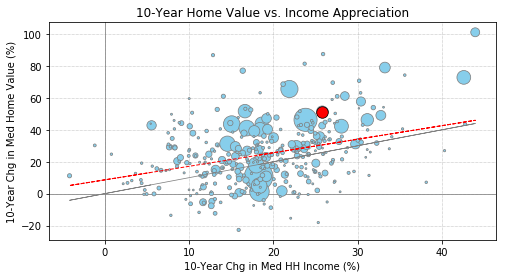

In [13]:
# Create scatterplot #1

# Define x and y values
income_chg = metro_main_df["10-Yr HH Income Chg"]
value_chg = metro_main_df["10-Yr Home Value Chg"]

# Create a dataframe for just San Diego to show separately in the charts
sandiego_df = metro_main_df.loc[metro_main_df["Metro Name"] == "San Diego, CA", :]
sdincome_chg = sandiego_df["10-Yr HH Income Chg"]
sdvalue_chg = sandiego_df["10-Yr Home Value Chg"]

# Set the chart scale
# plt.figure(figsize=((income_chg.max() - income_chg.min())/24, 
#                     (value_chg.max() - value_chg.min())/24))

# Plot points, labels, and title
plt.figure(figsize=(8,4))
plt.scatter(income_chg, value_chg, marker="o", facecolor="skyblue", edgecolor="grey",
            linewidth=0.75, zorder=2, s=metro_main_df["Population"]/25000)
plt.scatter(sdincome_chg, sdvalue_chg, marker="o", facecolor="red", edgecolor="black",
            linewidth=0.75, zorder=2, s=sandiego_df["Population"]/25000)
plt.xlabel("10-Year Chg in Med HH Income (%)")
plt.ylabel("10-Year Chg in Med Home Value (%)")
plt.title("10-Year Home Value vs. Income Appreciation")

# Create a regression line
(slope, intercept, _, _, _) = linregress(income_chg, value_chg)
fit = slope * income_chg + intercept
plt.plot(income_chg, fit, '--', zorder=3, color="red", linewidth=1)

# Draw a line that shows an where median home values increase
# at the same rate as median HH income
plt.plot(income_chg, income_chg, zorder=3, color='grey', linewidth=0.75)
#plt.axes().set_aspect('equal')

# Create gridlines
plt.axhline(y=0, color='grey', zorder=1, linewidth=0.75)
plt.axvline(x=0, color='grey', zorder=1, linewidth=0.75)
plt.grid(color='grey', zorder=1, linestyle='dotted', linewidth=0.5)

# Save graph
plt.savefig("../Visualizations/metro_scatter.png", dpi=180, bbox_inches="tight")

In [14]:
# Home many metros saw home values rise faster than income levels over the the past 10 years
val_more_inc = (metro_main_df["10-Yr Value-Income Ratio"] > 1)
val_more_inc.value_counts()

True     238
False    131
Name: 10-Yr Value-Income Ratio, dtype: int64

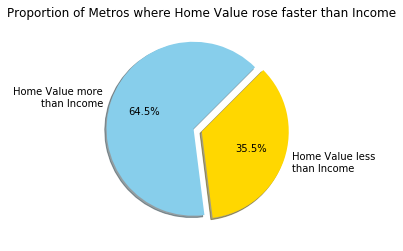

In [15]:
# Create pie chart #1

label=['Home Value more\nthan Income', "Home Value less\nthan Income"]
color = ["skyblue", "gold"]
explode = (0.1,0)
plt.figure(figsize=(8,4))
plt.pie((metro_main_df["10-Yr Value-Income Ratio"] > 1).value_counts(), autopct='%1.1f%%',
        labels=label, colors=color, explode=explode, shadow=True, startangle=45)
plt.title("Proportion of Metros where Home Value rose faster than Income")

# Save graph
plt.savefig("../Visualizations/val_more_inc_pie.png", dpi=180, bbox_inches="tight")

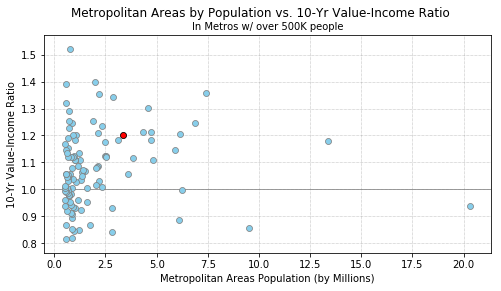

In [16]:
# Create scatterplot #2

# Create dataframe for metros with population over 1M
large_metros_df = metro_main_df.loc[metro_main_df["Population"] >= 500000, :]

# Plot points, labels, and title
plt.figure(figsize=(8,4))
plt.scatter(large_metros_df["Population"]/1000000,large_metros_df["10-Yr Value-Income Ratio"], marker="o", facecolor="skyblue", 
            edgecolor="grey", linewidth=0.75, zorder=2)
plt.scatter(sandiego_df["Population"]/1000000, sandiego_df["10-Yr Value-Income Ratio"], marker="o", facecolor="red",
            edgecolor="black", linewidth=0.75, zorder=2)
plt.xlabel("Metropolitan Areas Population (by Millions)")
plt.ylabel("10-Yr Value-Income Ratio")
plt.suptitle("Metropolitan Areas by Population vs. 10-Yr Value-Income Ratio")
plt.title("In Metros w/ over 500K people", fontsize=10)

# Create gridlines
plt.axhline(y=1, color='grey', zorder=1, linewidth=0.75)
plt.grid(color='grey', zorder=1, linestyle='dotted', linewidth=0.5)

# Save graph
plt.savefig("../Visualizations/ratio_metro_pop.png", dpi=180, bbox_inches="tight")

In [17]:
# How many metros over 500K people
large_metros_df["Metro Name"].count()

107

In [18]:
# Rank the metros by the 10-Yr Value-Income Ratio, descending
metro_sort10_df = large_metros_df.sort_values(by="10-Yr Value-Income Ratio", ascending=False)
metro_reidx10_df = metro_sort10_df[["Metro Name", "Population", "10-Yr Value-Income Ratio"]].reset_index(inplace = False)

In [19]:
# Where does San Diego rank by the 10-Yr Value-Income Ratio
SanDiego_rank = metro_reidx10_df.loc[metro_reidx10_df['Metro Name'] == "San Diego, CA"].index
print(f"San Diego ranks {SanDiego_rank[0]+1}")

San Diego ranks 20


In [20]:
# Show the ranked metro dataframe
output10_df = formatted_df(metro_sort10_df)
output10_df = output10_df.head(SanDiego_rank[0]+1)
output10_df.append(US_datafmt_df)

,Metro Name,Metro Rank,2008-Q4 Home Value,2018-Q4 Home Value,10-Yr Home Value Chg,2008-Q4 HH Income,2018-Q4 HH Income,10-Yr HH Income Chg,10-Yr Value-Income Ratio,2018-Q4 Value-Income Ratio,Population
395134,"Stockton, CA",77,"$204,500","$362,000",77.0%,"$55,263","$64,311",16.4%,1.52,5.63,"745,424"
395059,"San Jose, CA",34,"$623,400","$1,253,500",101.1%,"$86,370","$124,312",43.9%,1.40,10.08,"1,998,463"
394871,"Modesto, CA",102,"$182,100","$307,000",68.6%,"$52,012","$63,016",21.2%,1.39,4.87,"547,899"
394514,"Dallas-Fort Worth, TX",4,"$145,100","$240,200",65.5%,"$57,718","$70,361",21.9%,1.36,3.41,"7,399,662"
394775,"Las Vegas, NV",31,"$194,700","$278,000",42.8%,"$56,916","$60,084",5.6%,1.35,4.63,"2,204,079"
394530,"Denver, CO",21,"$225,500","$403,600",79.0%,"$60,444","$80,525",33.2%,1.34,5.01,"2,888,227"
394957,"Melbourne, FL",97,"$146,500","$211,200",44.2%,"$49,707","$54,234",9.1%,1.32,3.89,"589,162"
395025,"Riverside, CA",13,"$240,900","$365,400",51.7%,"$55,996","$65,311",16.6%,1.30,5.59,"4,580,670"
394440,"Fort Myers, FL",84,"$163,800","$232,900",42.2%,"$50,658","$55,770",10.1%,1.29,4.18,"739,224"
394399,"Boise City, ID",85,"$190,600","$274,900",44.2%,"$50,256","$57,744",14.9%,1.26,4.76,"709,845"


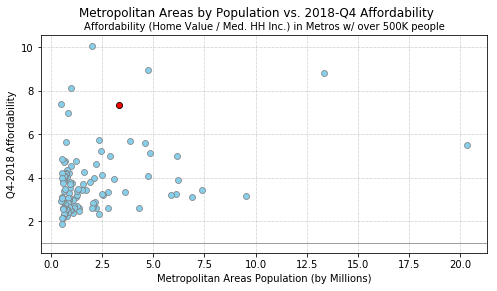

In [21]:
# Create scatterplot #3

# Plot points, labels, and title
plt.figure(figsize=(8,4))
plt.scatter(large_metros_df["Population"]/1000000,large_metros_df["2018-Q4 Value-Income Ratio"], marker="o", facecolor="skyblue", 
            edgecolor="grey", linewidth=0.75, zorder=2)
plt.scatter(sandiego_df["Population"]/1000000, sandiego_df["2018-Q4 Value-Income Ratio"], marker="o", facecolor="red",
            edgecolor="black", linewidth=0.75, zorder=2)
plt.xlabel("Metropolitan Areas Population (by Millions)")
plt.ylabel("Q4-2018 Affordability")
plt.suptitle("Metropolitan Areas by Population vs. 2018-Q4 Affordability")
plt.title("Affordability (Home Value / Med. HH Inc.) in Metros w/ over 500K people", fontsize=10)
# Create gridlines
plt.axhline(y=1, color='grey', zorder=1, linewidth=0.75)
plt.grid(color='grey', zorder=1, linestyle='dotted', linewidth=0.5)

# Save graph
plt.savefig("../Visualizations/afford_metro_pop.png", dpi=180, bbox_inches="tight")

In [22]:
# Rank the metros by affordability, descending
metro_sortQ4_df = large_metros_df.sort_values(by="2018-Q4 Value-Income Ratio", ascending=False)
metro_reidxQ4_df = metro_sortQ4_df[["Metro Name", "Population", "2018-Q4 Value-Income Ratio"]].reset_index(inplace = False)

In [23]:
# Where does San Diego rank by affordability
SanDiego_rank = metro_reidxQ4_df.loc[metro_reidxQ4_df['Metro Name'] == "San Diego, CA"].index
print(f"San Diego ranks {SanDiego_rank[0]+1}")

San Diego ranks 6


In [24]:
# Show the ranked metro dataframe
outputQ4_df = formatted_df(metro_sortQ4_df)
outputQ4_df = outputQ4_df.head(SanDiego_rank[0]+1)
outputQ4_df.append(US_datafmt_df)

,Metro Name,Metro Rank,2008-Q4 Home Value,2018-Q4 Home Value,10-Yr Home Value Chg,2008-Q4 HH Income,2018-Q4 HH Income,10-Yr HH Income Chg,10-Yr Value-Income Ratio,2018-Q4 Value-Income Ratio,Population
395059,"San Jose, CA",34,"$623,400","$1,253,500",101.1%,"$86,370","$124,312",43.9%,1.40,10.08,"1,998,463"
395057,"San Francisco, CA",11,"$556,800","$962,300",72.8%,"$75,481","$107,619",42.6%,1.21,8.94,"4,727,357"
753899,"Los Angeles-Long Beach-Anaheim, CA",2,"$444,600","$650,200",46.2%,"$59,422","$73,574",23.8%,1.18,8.84,"13,353,907"
753924,"Urban Honolulu, HI",54,"$496,600","$684,700",37.9%,"$72,295","$84,239",16.5%,1.18,8.13,"988,650"
395068,"Santa Rosa, CA",105,"$411,100","$632,700",53.9%,"$64,922","$85,599",31.8%,1.17,7.39,"504,217"
395056,"San Diego, CA",17,"$391,700","$592,700",51.3%,"$64,047","$80,565",25.8%,1.20,7.36,"3,337,685"
102001,United States,0,"$175,600","$223,900",27.5%,"$52,177","$63,301",21.3%,1.05,3.54,"325,719,178"


In [25]:
#over ratio of 1 means the housing value exceeded the incomes in the metro area. In the largest metros, most of the metro areas saw 
#a greater increase in the rates of houses than the rates of their median income. Metro areas where the income rates
#have exceeded the housing prices are in the minority, and include areas like New York.